# ***LGBM Balanced***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import os
import pickle  # For saving and loading the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, f1_score, make_scorer
import optuna
from sklearn.ensemble import RandomForestClassifier

import os
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import optuna
import joblib
import time
import numpy as np
pd.options.display.float_format = '{:.3f}'.format

In [2]:
df = pd.read_excel("../Preprocessed data.xlsx")
#df.columns

Model found. Loading from ../Models/lgbm_model_SMOTE_cv.pkl...
Study found. Loading from ../Study/optuna_study_LGBM_SMOTE_cv.pkl...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7240759010358273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7240759010358273
[LightGBM] [Warning] lambda_l2 is set=0.10547490783314122, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10547490783314122
[LightGBM] [Warning] lambda_l1 is set=1.7026928862163723e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7026928862163723e-08
[LightGBM] [Warning] bagging_fraction is set=0.49850042731151945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49850042731151945

Validation Metrics:
F1-Score (Validation): 0.8567
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      3211
           1       0

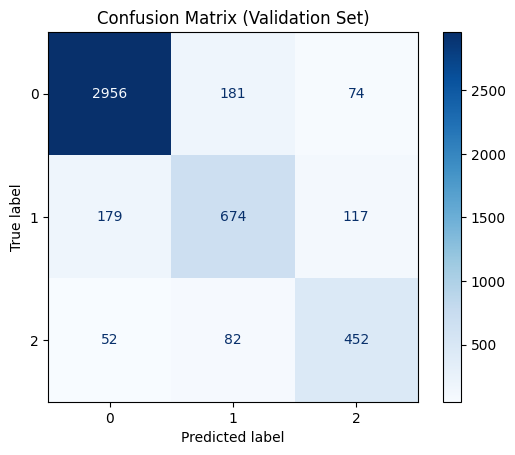

In [3]:
import os
import joblib
import lightgbm as lgb
import pandas as pd
import optuna
import numpy as np
import time
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold

# Cargar el dataset
X = df.drop(columns=["Cuenta", "Estado"])
y = df["Estado"]
X.columns = X.columns.str.replace(r"[^\w\d_]", "_", regex=True)

# Dividir en conjunto de entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Definir nombres de archivos
model_filename = "../Models/lgbm_model_SMOTE_cv.pkl"
study_filename = "../Study/optuna_study_LGBM_SMOTE_cv.pkl"

# Verificar si el modelo o el estudio existen
model_exists = os.path.exists(model_filename)
study_exists = os.path.exists(study_filename)

if model_exists:
    print(f"Model found. Loading from {model_filename}...")
    lgbm_model_balanced = joblib.load(model_filename)
else:
    print("Model not found. A new one will be trained.")

if study_exists:
    print(f"Study found. Loading from {study_filename}...")
    study_lgbm_balanced = joblib.load(study_filename)
else:
    print("Study not found. A new one will be created.")
    pruner = optuna.pruners.MedianPruner()
    study_lgbm_balanced = optuna.create_study(direction="minimize", pruner=pruner)

    def objective(trial):
        param = {
            "objective": "multiclass",
            "num_class": 3,
            "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
            "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 1.0, log=True),
            "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 1.0, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 31, 128),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
            "min_child_samples": trial.suggest_int("min_child_samples", 1, 50),
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3),
            "n_estimators": trial.suggest_int("n_estimators", 50, 200),
            "device": "gpu"
        }

        f1_scores = []
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        for train_idx, val_idx in kfold.split(X_train, y_train):
            X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
            X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]

            # Aplicar SMOTE solo en el fold de entrenamiento
            smote = SMOTE(sampling_strategy="auto", random_state=42, k_neighbors=5)
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)

            dtrain = lgb.Dataset(X_train_resampled, label=y_train_resampled)
            dval = lgb.Dataset(X_val_fold, label=y_val_fold)

            pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "multi_logloss")
            model = lgb.train(param, dtrain, valid_sets=[dval], callbacks=[pruning_callback])

            y_val_pred = model.predict(X_val_fold)
            pred_labels = np.argmax(y_val_pred, axis=1)
            f1_scores.append(f1_score(y_val_fold, pred_labels, average="weighted"))

            if trial.should_prune():
                raise optuna.TrialPruned()

        return np.mean(f1_scores)

    if not model_exists:
        start_time = time.time()
        study_lgbm_balanced.optimize(objective, n_trials=100)
        end_time = time.time()
        joblib.dump(study_lgbm_balanced, study_filename)
        print(f"Study saved as {study_filename}")
        print(f"Optimization time: {end_time - start_time:.2f} seconds")

if not model_exists:
    best_params = study_lgbm_balanced.best_params
    lgbm_model_balanced = lgb.LGBMClassifier(
        **best_params,
        random_state=42,
    )

    # Aplicar SMOTE al conjunto completo de entrenamiento antes del ajuste final
    smote = SMOTE(sampling_strategy="auto", random_state=42, k_neighbors=5)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Entrenar el modelo final
    lgbm_model_balanced.fit(
        X_train_resampled,
        y_train_resampled,
        eval_set=[(X_train_resampled, y_train_resampled), (X_val, y_val)],
    )

    # Guardar modelo
    joblib.dump(lgbm_model_balanced, model_filename)
    print(f"Model saved as {model_filename}")

# Evaluación en conjunto de validación
y_val_pred = lgbm_model_balanced.predict(X_val)

print("\nValidation Metrics:")
print(f"F1-Score (Validation): {f1_score(y_val, y_val_pred, average='weighted'):.4f}")
print(classification_report(y_val, y_val_pred))

conf_matrix_val = confusion_matrix(y_val, y_val_pred)
disp_val = ConfusionMatrixDisplay(conf_matrix_val, display_labels=lgbm_model_balanced.classes_)
disp_val.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Validation Set)")
plt.show()


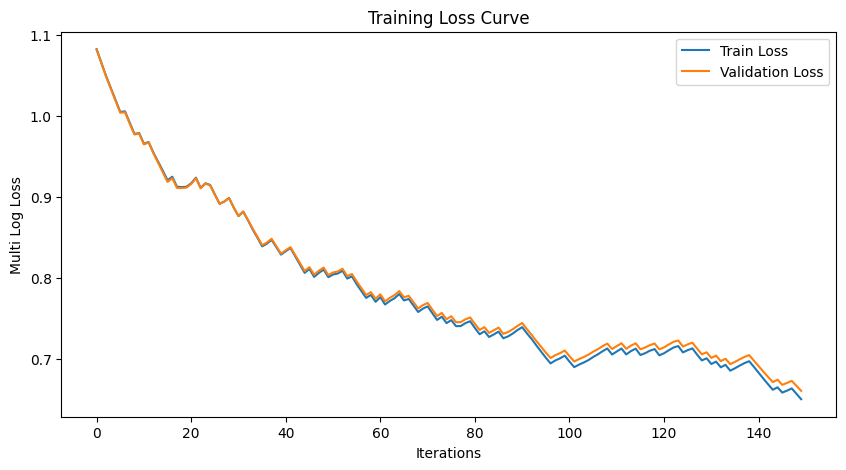

In [4]:
# Graficar curva de pérdida
results = lgbm_model_balanced.evals_result_
plt.figure(figsize=(10, 5))
plt.plot(results['training']['multi_logloss'], label='Train Loss')
plt.plot(results['valid_1']['multi_logloss'], label='Validation Loss')
plt.xlabel("Iterations")
plt.ylabel("Multi Log Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

In [5]:
from reporte_metricas import guardar_reporte

guardar_reporte(y_val, y_val_pred, "LGBM Model Balanced", "./Metrics/Train_Metrics.csv", "./Metrics/Train_Metrics.json")

📂 Reporte de LGBM Model Balanced guardado correctamente.


In [6]:
lgbm_model_balanced

/home/ssilvera/Escritorio/Proyectos/Modelo_pagos/.venv/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


LGBMClassifier(bagging_fraction=0.49850042731151945, bagging_freq=6,
               boosting_type='dart', feature_fraction=0.7240759010358273,
               lambda_l1=1.7026928862163723e-08, lambda_l2=0.10547490783314122,
               learning_rate=0.013906465674310552, min_child_samples=35,
               n_estimators=150, num_leaves=125, random_state=42)

## ***Test Metrics***

In [7]:
# **Evaluación en el conjunto de prueba**
y_test_pred = lgbm_model_balanced.predict(X_test)

# Calcular F1-score, reporte de clasificación y matriz de confusión para `test`
f1_test = f1_score(y_test, y_test_pred, average="weighted")
print("\nTest Metrics:")
print(f"F1-Score (Test): {f1_test:.4f}")
print(classification_report(y_test, y_test_pred))



[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7240759010358273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7240759010358273
[LightGBM] [Warning] lambda_l2 is set=0.10547490783314122, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10547490783314122
[LightGBM] [Warning] lambda_l1 is set=1.7026928862163723e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7026928862163723e-08
[LightGBM] [Warning] bagging_fraction is set=0.49850042731151945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49850042731151945

Test Metrics:
F1-Score (Test): 0.8589
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      3212
           1       0.73      0.71      0.72       969
           2       0.69      0.75      0.72       586

    accuracy                           0.86      4767
 

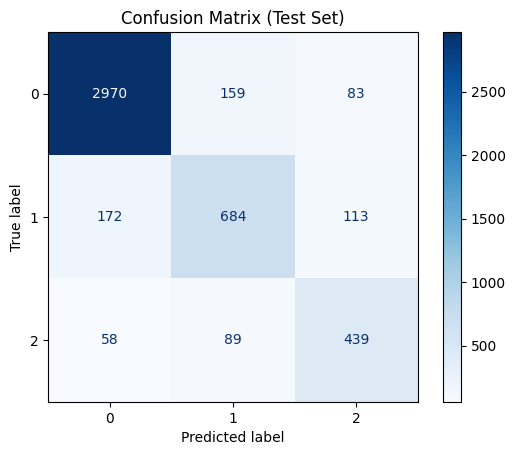

In [8]:
# Matriz de confusión para `test`
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(conf_matrix_test, display_labels=lgbm_model_balanced.classes_)
disp_test.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Test Set)")
plt.show()

## ***Optuna Visualization***

In [9]:
optuna.visualization.plot_optimization_history(study_lgbm_balanced)

In [10]:
optuna.visualization.plot_parallel_coordinate(study_lgbm_balanced)

In [11]:
# Extract F1-scores from each trial in the study
f1_scores = [study_lgbm_balanced.trials[i].value for i in range(len(study_lgbm_balanced.trials))]  # Get the F1-score for each trial

# Create a plotly figure
fig = go.Figure()

# Add a line plot to the figure with the F1-scores
fig.add_trace(go.Scatter(
    x=list(range(len(study_lgbm_balanced.trials))),  # X-axis: Trial number
    y=f1_scores,  # Y-axis: F1-score values
    mode='markers+lines',  # Display both markers and lines
    name='F1-score',  # Label for the line
    line=dict(color='blue'),  # Line color
    marker=dict(color='blue', size=6)  # Marker style
))

# Update layout for the plot
fig.update_layout(
    title="F1-Score Evolution During Optuna Optimization",  # Title of the plot
    xaxis_title="Trial",  # Label for X-axis
    yaxis_title="F1-Score",  # Label for Y-axis
    template="plotly_dark",  # Use dark template for better visibility
    showlegend=False  # Hide legend
)

# Show the plot
fig.show()


In [12]:
optuna.visualization.plot_slice(study_lgbm_balanced, params=['boosting_type', 'lambda_l1', 'lambda_l2', 'num_leaves', 'bagging_fraction', 'feature_fraction', 'bagging_freq', 'min_child_samples', 'learning_rate', 'n_estimators'])

In [13]:
optuna.visualization.plot_param_importances(study_lgbm_balanced)

## ***Feature Importances***

In [14]:
# Extract feature importances from the trained model
importances = lgbm_model_balanced.feature_importances_

# Create a DataFrame for easier plotting
feature_names = X_train.columns  # Use the features from the final training set
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance and select the top 20
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot the feature importance using Plotly
fig = px.bar(importance_df, 
             x='Feature', 
             y='Importance', 
             title='Top 20 Feature Importance of the Decision Tree Model',
             labels={'Feature': 'Feature Name', 'Importance': 'Importance Score'},
             color='Importance',  # Color bars based on importance
             color_continuous_scale='Viridis',  # Use a color scale for better visualization
             text='Importance')  # Display importance values on the bars

# Rotate X-axis labels for better readability
fig.update_layout(xaxis_tickangle=45)

# Show the plot
fig.show()


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7240759010358273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7240759010358273
[LightGBM] [Warning] lambda_l2 is set=0.10547490783314122, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10547490783314122
[LightGBM] [Warning] lambda_l1 is set=1.7026928862163723e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7026928862163723e-08
[LightGBM] [Warning] bagging_fraction is set=0.49850042731151945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49850042731151945


/home/ssilvera/Escritorio/Proyectos/Modelo_pagos/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



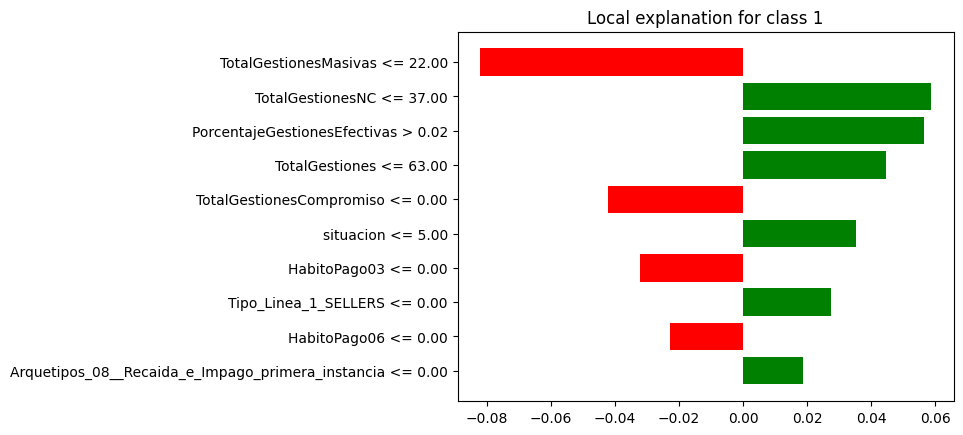

In [15]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,               # Training data (must be a numpy array or pandas dataframe)
    feature_names=X_train.columns,                    # Feature names (column names)
    class_names=y_train.unique(),                     # Target class names (unique classes in target column)
    mode='classification',                             # We're explaining a classification problem
    training_labels=y_train.values                     # Labels for training data
)

# Example 1: Explaining the prediction for the 100th instance in the test set
i = 3
instance = X_test.iloc[i].values.reshape(1, -1)  # Reshape for LIME

exp = explainer.explain_instance(
    data_row=instance[0],                           # Instance to explain
    predict_fn=lgbm_model_balanced.predict_proba              # Model's predict function (predict_proba for probabilities)
)

# Show explanation in notebook (table of feature importances)
exp.show_in_notebook(show_table=True, show_all=False)

# Generate a plot for the explanation
fig = exp.as_pyplot_figure()
plt.show()

<Axes: title={'center': 'Split value histogram for feature with name TotalGestionesMasivas'}, xlabel='Feature split value', ylabel='Count'>

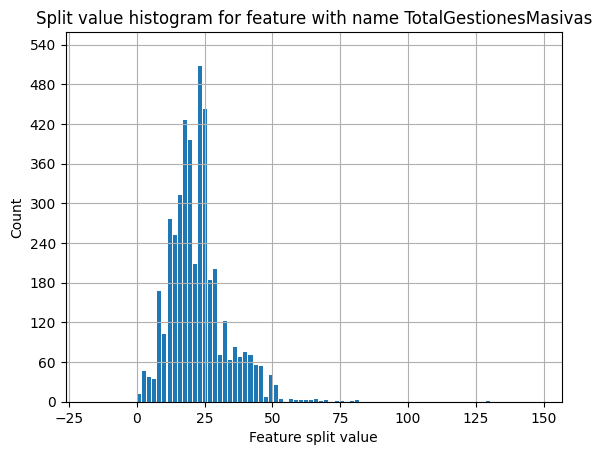

In [16]:
lgb.plot_split_value_histogram(lgbm_model_balanced, feature="TotalGestionesMasivas")

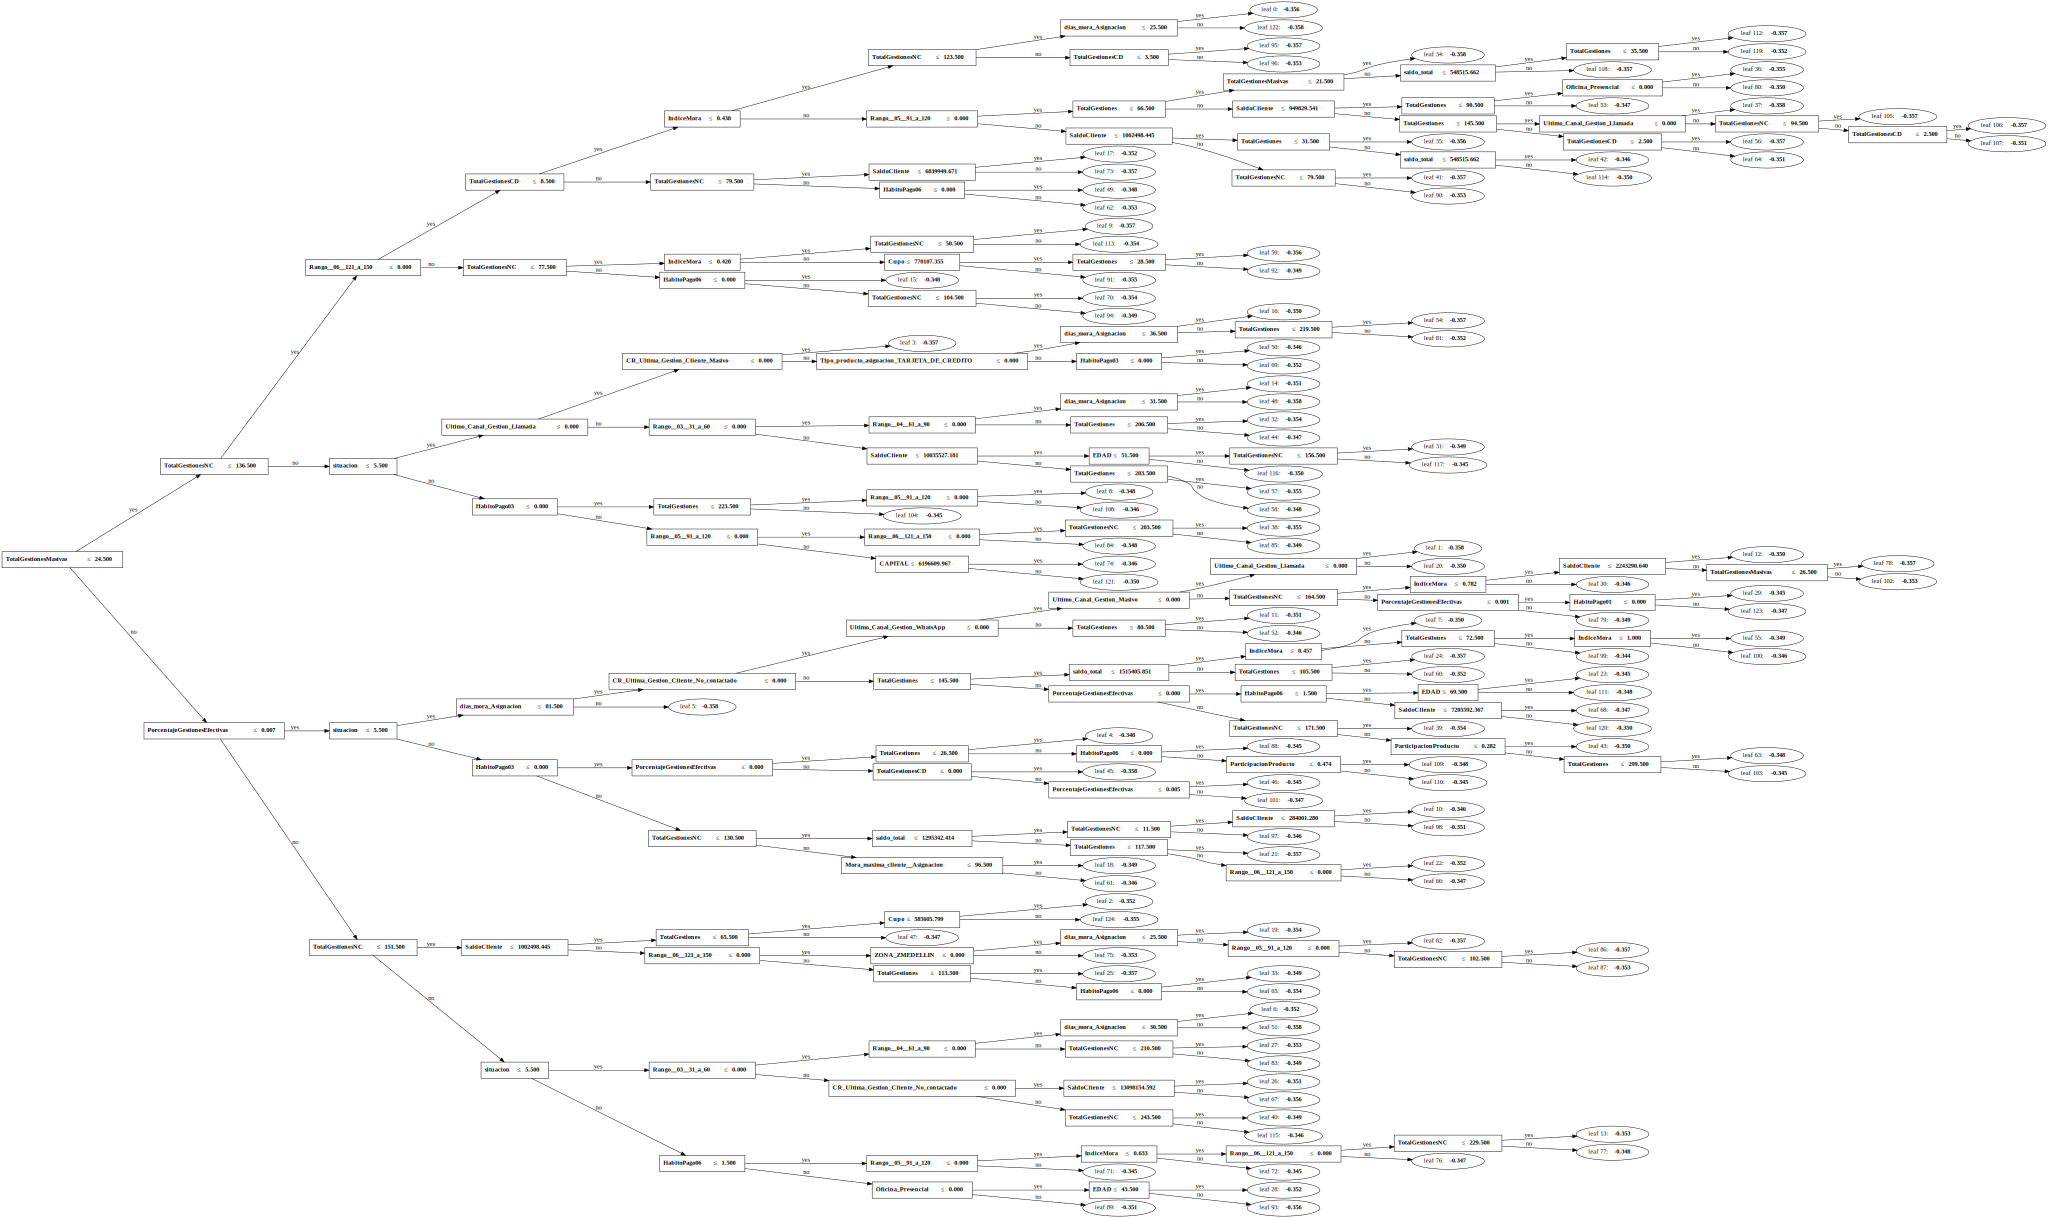

In [17]:
import graphviz

dot = lgb.create_tree_digraph(lgbm_model_balanced, tree_index=0)
dot.render("./img/lgbm_tree_bal")  # Guarda el gráfico en un archivo
dot  # Muestra el gráfico en Jupyter Notebook


In [18]:
from reporte_metricas import guardar_reporte

guardar_reporte(y_test, y_test_pred, "LGBM Model Balanced", "./Metrics/Test_Metrics.csv", "./Metrics/Tes_Metrics.json")

📂 Reporte de LGBM Model Balanced guardado correctamente.
